# Particle localisation in a confocal image

First, import necessary library to load and display images

In [2]:
import numpy as np
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
from pyrtrack.finders import MultiscaleBlobFinder, get_deconv_kernel, deconvolve
from pyrtrack import rescale
%matplotlib inline

We also need to define functions to quickly display tracking results.

In [3]:
def draw_circles(xs, ys, rs, **kwargs):
    for x,y,r in zip(xs,ys,rs):
        circle = plt.Circle((x,y), radius=r, **kwargs)
        plt.gca().add_patch(circle)
        
def display_cuts(imf, centers, X=30, Y=25, Z=30):
    """Draw three orthogonal cuts with corresponding centers"""
    plt.subplot(1,3,1);
    draw_circles(centers[:,0], centers[:,1], centers[:,-2], facecolor='none', edgecolor='g')
    plt.imshow(imf[Z], 'hot',vmin=0,vmax=255);
    plt.subplot(1,3,2);
    draw_circles(centers[:,0], centers[:,2], centers[:,-2], facecolor='none', edgecolor='g')
    plt.imshow(imf[:,Y], 'hot',vmin=0,vmax=255);
    plt.subplot(1,3,3);
    draw_circles(centers[:,1], centers[:,2], centers[:,-2], facecolor='none', edgecolor='g')
    plt.imshow(imf[:,:,X], 'hot',vmin=0,vmax=255);

## Raw confocal image

Load the test data, which is only a detail of a full 3D stack. Display different cuts.

Note that raw confocal images are heavily distorted in the $z$ direction. We actually have 4 particles in the image: two small on top of each other, one on the side and a slightly larger below and on the side.

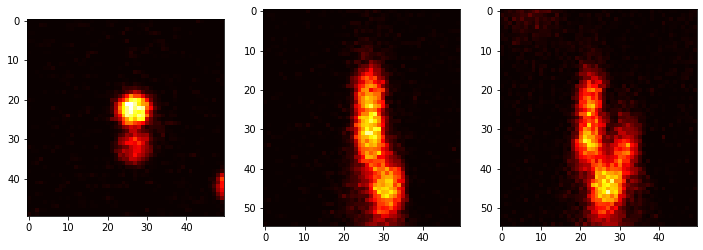

In [4]:
imf = np.fromfile('Z_elong.raw', dtype=np.uint8).reshape((55,50,50))
fig = plt.figure(figsize=(12,6))
plt.subplot(1,3,1).imshow(imf[30], 'hot',vmin=0,vmax=255);
plt.subplot(1,3,2).imshow(imf[:,25], 'hot',vmin=0,vmax=255);
plt.subplot(1,3,3).imshow(imf[:,:,30], 'hot',vmin=0,vmax=255);

Create a finder object of the same shape as the image. Seamlessly work with 3D images.

In [5]:
finder = MultiscaleBlobFinder(imf.shape, Octave0=False, nbOctaves=4)

Feed the image in the tracker with default tracking parameters. The output has four columns : $(x,y,z,r,i)$ where $r$ is a first approximation of the radius of the particle (see below) and $i$ is a measure of the brightness of the particle.

(3, 5)
smallest particle detected has a radius of 4.39349 px


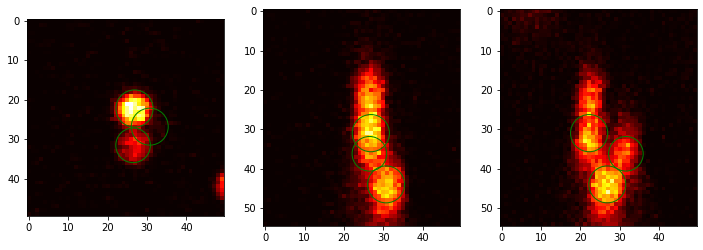

In [6]:
centers = finder(imf)
print(centers.shape)
print(f"smallest particle detected has a radius of {centers[:,-2].min():g} px")
fig = plt.figure(figsize=(12,6))
display_cuts(imf, centers)

This is a pretty bad job. Only two particle detected correctly. The top and side small particles are not detected.

Let us try not to remove overlapping.

(4, 5)
smallest particle detected has a radius of 4.39349 px


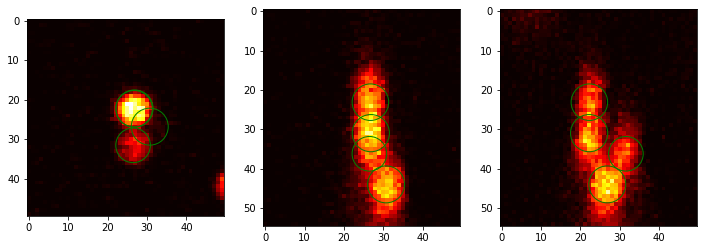

In [7]:
centers = finder(imf, removeOverlap=False)
print(centers.shape)
print(f"smallest particle detected has a radius of {centers[:,-2].min():g} px")
fig = plt.figure(figsize=(12,6))
display_cuts(imf, centers)

Now we have all the particles.

We have two effects at play here that fool the overlap removal:
 - The radii guessed by the algorithm are too large.
 - The particles aligned along $z$ are localised too close together.

Both effects are due to the elongation in $z$.

## Simple deconvolution of a confocal image

The image $y$ acquired by a microscope can be expressed as 


$y = x \star h + \epsilon, $

where $\star$ is the convolution operator, $x$ is the perfect image, $h$ is the point spread function (PSF) of the microscope and $\epsilon$ is the noise independent of both $x$ and $h$. The process of estimating $x$ from $y$ and some theoretical or measured expression of $h$ is called deconvolution. Deconvolution in the presence of noise is a difficult problem. Hopefully here we do not need to reconstruct the original image, but only our first Gaussian blurred version of it. Indeed, after a reasonable amount of blur in three dimensions, the noise can be neglected and we thus obtain:

$ y_0 \approx G_0 \star h, $

or in Fourier space

$\mathcal{F}[y_0] = \mathcal{F}[G_0] \times \mathcal{F}[h]. $

Once $\mathcal{F}[h]$ is known the deconvolution reduces to a simple division in Fourier space. 

### Measuring the kernel

$\mathcal{F}[h]$ should be measured in an isotropic system and in the same conditions (magnification, number of pixels, indices of refraction, etc.) as the experiment of interest.

Since a 3D image large enough to be isotropic is too big to share in an example, I just use the image of interest. Don't do this at home.

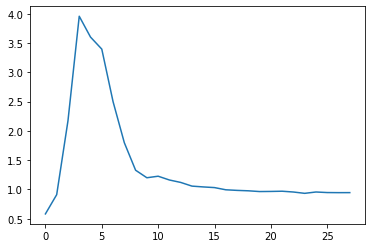

In [8]:
imiso = np.fromfile('Z_elong.raw', dtype=np.uint8).reshape((55,50,50))
kernel = get_deconv_kernel(imiso)
plt.plot(kernel);

The `kernel` variable here is actually $1/\mathcal{F}[h]$

### Kernel test

What not to do: deconvolve the unblurred image.

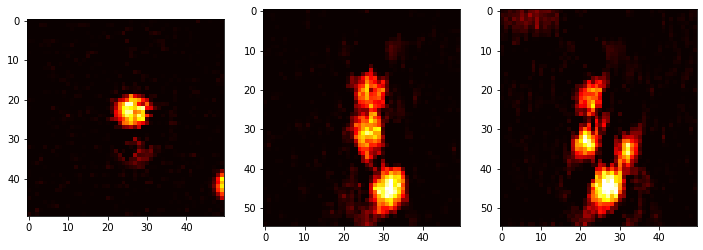

In [9]:
imd = deconvolve(imf, kernel)
fig, axs = plt.subplots(1,3, figsize=(12,6))
axs[0].imshow(imd[30], 'hot',vmin=0,vmax=255);
axs[1].imshow(imd[:,25], 'hot',vmin=0,vmax=255);
axs[2].imshow(imd[:,:,30], 'hot',vmin=0,vmax=255);

Noisy isn't it? Yet we have saturated the color scale between 0 and 255, otherwise artifacts would be even more apparent.

What the program will actually do: deconvolved the blurred image.

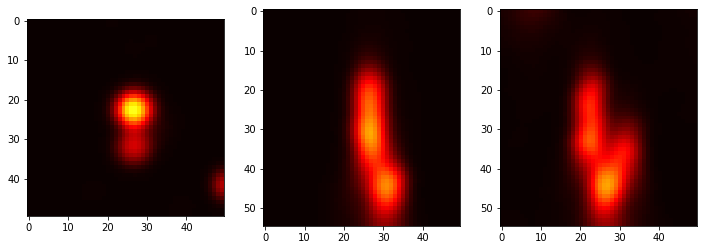

In [10]:
imb = gaussian_filter(imf.astype(float), 1.6)
fig, axs = plt.subplots(1,3, figsize=(12,6))
axs[0].imshow(imb[30], 'hot',vmin=0,vmax=255);
axs[1].imshow(imb[:,25], 'hot',vmin=0,vmax=255);
axs[2].imshow(imb[:,:,30], 'hot',vmin=0,vmax=255);

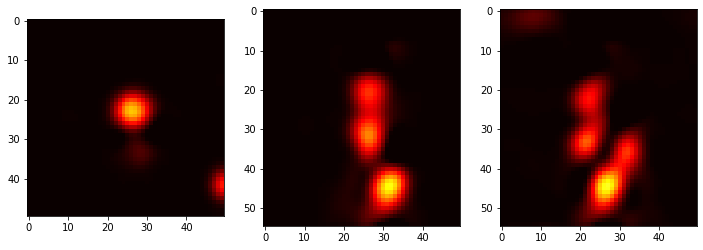

In [11]:
imbd = deconvolve(imb, kernel)
fig, axs = plt.subplots(1,3, figsize=(12,6))
axs[0].imshow(imbd[30], 'hot',vmin=0,vmax=255);
axs[1].imshow(imbd[:,25], 'hot',vmin=0,vmax=255);
axs[2].imshow(imbd[:,:,30], 'hot',vmin=0,vmax=255);

The way the noise is amplified by deconvolution is obvious when we compare the histograms of the 4 versions of the image.

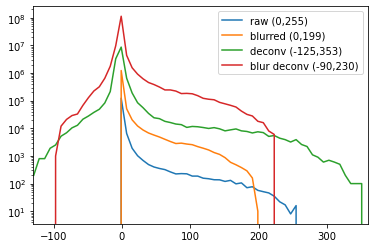

In [12]:
for i, (l, im) in enumerate(zip(['raw', 'blurred', 'deconv', 'blur deconv'], [imf, imb, imd, imbd])):
    plt.plot(
             np.arange(-129,363,8), 
             np.histogram(im, np.arange(-129,371,8))[0]*10**i, 
             label=l+' (%d,%d)'%(im.min(), im.max()));
plt.xlim(-130,360);
plt.yscale('log');
plt.legend(loc='upper right');

Obviously negative values should be discarded, and will be discarded by the algorithm.

### Localisation using deconvolved image

Not removing the overlaping particles, we use the deconvolution kernel.

(5, 5)
smallest particle detected has a radius of 3.52078 px


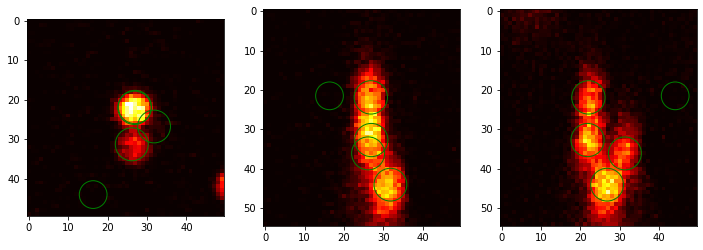

In [13]:
centers = finder(imf, removeOverlap=False, deconvKernel=kernel)
print(centers.shape)
print(f"smallest particle detected has a radius of {centers[:,-2].min():g} px")
fig = plt.figure(figsize=(12,6))
display_cuts(imf, centers)

All particles are found and actually they are not overlaping. However we got a spurious detection, probably some noise that got amplified by the deconvolution. It is easily removed by a threshold in intensity.

In [14]:
print(centers)

[[ 16.31334384  44.07373885  21.50444345   3.52078126  -0.37019082]
 [ 26.79860906  22.0435863   21.89833819   4.23366033 -15.95536745]
 [ 26.92095001  21.83422163  32.72685299   4.21882833 -17.3271687 ]
 [ 26.11610631  31.30829898  36.11323148   4.18214472 -21.06731591]
 [ 31.77923381  26.78655827  44.05564076   4.15859327 -20.1763175 ]]


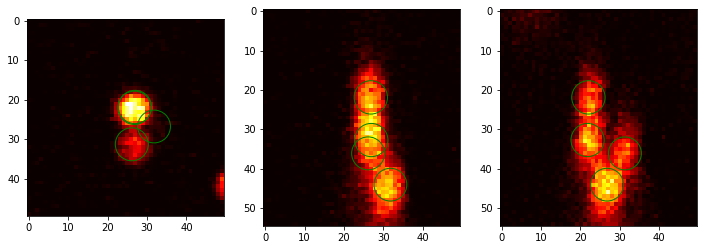

In [15]:
centers = centers[centers[:,-1]<-1]
fig = plt.figure(figsize=(12,6))
display_cuts(imf, centers)

We can also display the results with respect to the blurred and deconvolved version of the image that we can find by introspection.

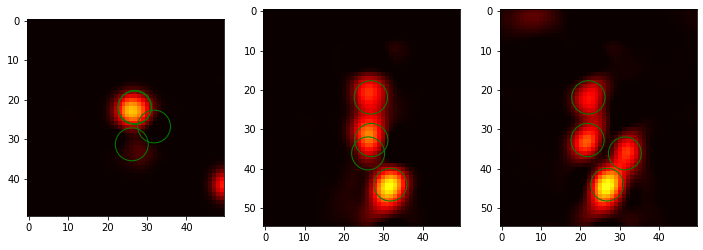

In [16]:
fig = plt.figure(figsize=(12,6))
display_cuts(finder.octaves[1].layersG[0], centers)

## From scales to sizes

This is pretty much like in 2D.

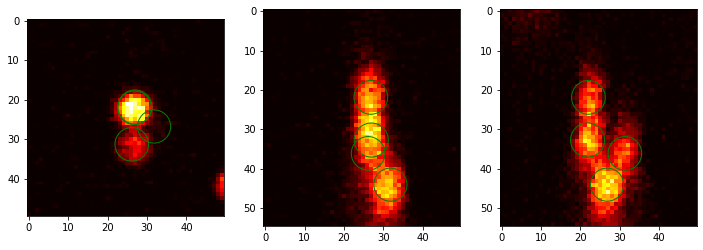

In [17]:
s = rescale.radius2sigma(centers[:,-2], dim=3)
bonds, dists = rescale.get_bonds(positions=centers[:,:-2], radii=centers[:,-2], maxdist=3.0)
brights1 = rescale.solve_intensities(s, bonds, dists, centers[:,-1])
radii1 = rescale.global_rescale_intensity(s, bonds, dists, brights1)
centers2 = np.copy(centers)
centers2[:,-2] = radii1

fig = plt.figure(figsize=(12,6))
display_cuts(imf, centers2)